In [2]:
###   Imports and Logging   ###
# Default Python stuff
import sys
import logging
import math
import copy
from dataclasses import dataclass, field, replace
from collections import namedtuple
# SciPy stuff
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib import __version__ as pltver
import matplotlib.ticker as ticker
# Sci-Kit Aero stuff
from skaero.atmosphere import coesa
from skaero import __version__ as skver

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format=' %(asctime)s -  %(levelname)s -  %(message)s'
)
# Spit out the runtime info for reproducibility
logging.info('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
logging.info('Python version: {}'.format(sys.version))
logging.info('Author: Benjamin Crews')
logging.info('Numpy version: {}'.format(np.version.version))
logging.info('Pandas version: {}'.format(pd.__version__))
logging.info('Matplotlib version: {}'.format(pltver))
logging.info('SciKit-Aero version: {}'.format(skver))
logging.info('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')

 2020-04-17 14:04:33,478 -  INFO -  =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
 2020-04-17 14:04:33,480 -  INFO -  Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
 2020-04-17 14:04:33,481 -  INFO -  Author: Benjamin Crews
 2020-04-17 14:04:33,481 -  INFO -  Numpy version: 1.16.2
 2020-04-17 14:04:33,481 -  INFO -  Pandas version: 0.24.2
 2020-04-17 14:04:33,482 -  INFO -  Matplotlib version: 3.0.3
 2020-04-17 14:04:33,482 -  INFO -  SciKit-Aero version: 0.1
 2020-04-17 14:04:33,483 -  INFO -  =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [145]:
### Classes

# This cell contains the basic class definition. One the most important classes will be the Helicopter class.
# This class is the whole purpose of the 'OOP-Conversion' branch, to transition the code to an Object-Oriented
# Philosophy, which will drastically decrese complexity for funtion calls and scale the capability.
@dataclass
class Helicopter():
    '''
    This class represents a helicopter with typical design features.
    These features are:
       Single Main Rotor,
       Single Tail Rotor,
       No shared lift or forward thrusters
       
    The basic Helicopter class has attributes and properties (according to Python definitions).
    Defaults are set for all values, so be careful with results before checking that all your
    input values (and units) are correct!
    
    This class uses a constant equivalent chord for all blades, and an efficiency factor
    must be used to estimate real performance based on this. No root cut-out is available.
    '''
    ## Utility Attributes
    name: str = field(default='Tim the Enchanter')
    rotors: tuple = ('MR', 'TR')
    
    ## Main Rotor Data
    MR_dia: float = field(default=10, metadata={'units':'ft'})
    MR_b: int = field(default=2, metadata={'units':''})
    MR_ce: float = field(default=10.4, metadata={'units':'in'})
    MR_Omega: float = field(default=43.2, metadata={'units':'rad/s'})
    MR_cd0: float = field(default=0.0080, metadata={'units':''})
    
    ## Tail Rotor Data
    TR_dia: float = field(default=2, metadata={'units':'ft'})
    TR_b: int = field(default=2, metadata={'units':''})
    TR_ce: float = field(default=6, metadata={'units':'in'})
    TR_Omega: float = field(default=20, metadata={'units':'rad/s'})
    TR_cd0: float = field(default=0.015, metadata={'units':''})
    
    ## Airframe Data
    GW_empty: float = field(default=1000, metadata={'units':'lbs'})
    GW_fuel: float = field(default=0, metadata={'units':'lbs'})
    GW_payload: float = field(default=0, metadata={'units':'lbs'})
    download: float = field(default=0.03, metadata={'units':'.%'})
    HIGE_factor: float = field(default=1.2)
    # Equivalent flat-plate-drag area
    fe: float = field(default=5, metadata={'units':'ft2'})
    # Tail length to TR center of thrust
    l_tail: float = field(default=15, metadata={'units':'ft'})
    # Vertical Tail Area
    S_vt: float = field(default=15, metadata={'units':'ft2'})
    # Coefficient of Lift for the vertical tail
    cl_vt: float = field(default=0.1, metadata={'units':''})
    # Vertical tail aspect ratio
    AR_vt: float = field(default=3, metadata={'units':''})
        
    ## Engine Data
    eta_MRxsmn: float = field(default=0.985, metadata={'units':'.%'})
    eta_TRxsmn: float = field(default=0.9712, metadata={'units':'.%'})
    eta_xsmn_co: float = field(default=0.986, metadata={'units':'.%'})
    pwr_acc: float = field(default=10, metadata={'units':'hp'})
    eta_inst: float = field(default=0.95, metadata={'units':'.%'})
    xsmn_lim: float = field(default=674, metadata={'units':'hp'})
    pwr_lim: float = field(default=813, metadata={'units':'hp'})
    # Normalized fuel curve
    bsfc_0: float = field(default=1.839)
    bsfc_1: float = field(default=-8.754E-02)
    bsfc_2: float = field(default=2.52E-03)
    bsfc_3: float = field(default=-3.77E-05)
    bsfc_4: float = field(default=2.822E-07)
    bsfc_5: float = field(default=-8.331E-10)

    
    def __post_init__(self):
        '''
        This method automatically calculates the extra input characteristics,
        which are based on the defined values.
        '''
        self.MR_R = self.MR_dia/2
        self.MR_A = math.pi * self.MR_R**2
        self.MR_vtip = self.MR_Omega * self.MR_R
        self.MR_sol = self.MR_b*self.MR_ce/(12*math.pi*self.MR_R)
        
        self.TR_R = self.TR_dia/2
        self.TR_A = math.pi * self.TR_R**2
        self.TR_vtip = self.TR_Omega * self.TR_R
        self.TR_sol = self.TR_b*self.TR_ce/(12*math.pi*self.TR_R)
        
    
    def __str__(self) -> str:
        '''
        Human-friendly representation of the helicopter class
        '''
        out = '-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-\n'
        out += f'{self.name:^45}'
        out += f'\nRotors: {self.rotors}'
        out += '\n-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-'
        out += '\nMain Rotor Inputs:'
        for k,v in self.__dict__.items():
            if k.startswith('MR'):
                out += '\n{:>17}: {:>7.3f} [{}]'.format(k, v, self.get_units(k))
                
        out += '\n-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-'
        out += '\nTail Rotor Inputs:'
        for k,v in self.__dict__.items():
            if k.startswith('TR'):
                out += '\n{:>17}: {:>7.3f} [{}]'.format(k, v, self.get_units(k))
                
        out += '\n-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-'
        out += '\nAirframe Data:'
        for k in ['GW_empty', 'GW_fuel', 'GW_payload', 'download', 'HIGE_factor', 'fe', 'l_tail', 'S_vt', 'cl_vt', 'AR_vt']:
            out += '\n{:>17}: {:>7.3f} [{}]'.format(k, self.__dict__[k], self.get_units(k))
            
        out += '\n-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-'
        out += '\nEngine Data:'
        for k in ['eta_MRxsmn', 'eta_TRxsmn', 'eta_xsmn_co', 'eta_inst', 'xsmn_lim', 'pwr_lim']:
            out += '\n{:>17}: {:>7.3f} [{}]'.format(k, self.__dict__[k], self.get_units(k))
        
        out += '\n-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-'
        return out
                
    
    def get_units(self, attribute_name) -> str:
        '''Returns the units from the metadata definition of the attribute.'''
        try:
            return self.__dataclass_fields__[attribute_name].metadata['units']
        except KeyError:
            return ''
        
    
    @property
    def GW(self):
        return self.GW_empty + self.GW_fuel + self.GW_payload
    
    
    def bsfc(self, pwr) -> float:
        '''
        This method returns the bsfc based on a certain power setting.
        Returned value is in units of lbs/(hp*hr)
        '''
        sfc = self.bsfc_0 + self.bsfc_1*pwr + self.bsfc_2*pwr**2 + self.bsfc_3*pwr**3 \
             + self.bsfc_4*pwr**4 + self.bsfc_5*pwr**5
        return sfc
    
    
    def burn(self, fuel):
        '''
        This method burns an amount of fuel, reducing the fuel weight by the amount burned.
        '''
        if fuel > self.GW_fuel:
            raise ValueError('More fuel required than remaining!')
        else:
            self.GW_fuel -= fuel
            
    
    def unload(self, weight):
        '''
        This method, similar to burn, removes weight from the aircraft by unloading a weight of payload.
        '''
        if weight > self.GW_payload:
            raise ValueError('More unload payload requested than remaining!')
        else:
            self.GW_payload -= weight
    
    
    def idle(self, pwr: float = 20):
        '''
        This method evaluates the fuel consumption for ground idle operations.
        Fuel consumption is returned in units of lb/hr. (This is the default
        bsfc curve)
        
        A ground idle power setting of 20% is assumed by default.
        '''
        sfc = self.bsfc(pwr)
        burn = sfc*pwr*self.pwr_lim/100
        return burn
    
    
    def HOGE(self,
             atm,
             Thrust = None,
             delta_1: float = -0.0216,
             delta_2: float = 0.4,
             k_i: float = 1.1,
             Vroc: float = 0
            ) -> list:
        '''
        This method calculates Hover Out of Ground Effect performance.
        
        Inputs:
            atm is an Environment class object, which provides altitude and temperature.
            delta_1 is the second term in the 3-part drag equation (default to -0.0216 based on literature)
            delta_2 is the third term in the 3-part drag equation (default to 0.4 based on literature)
            k_i is the "efficiency factor" which includes losses for non-uniform inflow, and non-ideal twist.
            Vroc is the vertical rate of climb, in ft/min.
            
        Returns a list of metrics.
                  a = 3D lift coefficient [cl/rad]
            delta_0 = corrected, compressible drag coefficient (1st term in 3-term drag equation)
                 Ct = coefficient of thrust
               Cq_i = coefficient of torque, induced velocity contribution
               Cq_v = coefficient of torque, vroc contribution
               Cq_0 = coefficient of torque, 1st term drag
               Cq_1 = coefficient of torque, 2nd term drag
               Cq_2 = coefficient of torque, 3rd term drag
                  Q = Main Rotor Torque
               P_MR = Main Rotor required Power
               P_TR = Tail Rotor required Power
            SHP_ins = Total shaft horsepower of the installed engine
          SHP_unins = Total shaft horsepower of an uninstalled engine (spec)
        '''
        # If thrust is not specified (default),
        # Set it to weight plus download
        if not Thrust:
            Thrust = self.GW*(1+self.download)
        
        Vroc = Vroc/60   # Convert the climb rate into ft/s for calculations.
        
        ###   Airfoil Lift factor correction from 2d to 3d   ###
        AR = 12*self.MR_R/self.MR_ce
        a_0 = 2*math.pi
        a = a_0 / (1 + a_0/(math.pi*AR))
        
        ###   Compressibility Correction Factor   ###
        c_sound = math.sqrt(1.4*1716.4*atm.T)
        mach_08 = self.MR_vtip*0.8/c_sound
        delta_0 = self.MR_cd0/math.sqrt(abs(mach_08**2 - 1))
        
        Ct = Thrust/(atm.rho*self.MR_A*self.MR_vtip**2)
        
        # Get B correction for tip-loss = 1 - (sqrt(2*Ct)/b)
        B = 1 - math.sqrt(2*Ct)/self.MR_b
        
        # MR Torque/Power Calculations
        Cq_i = 0.5*Ct*math.sqrt( (Vroc/(self.MR_Omega*self.MR_R))**2 + 2*Ct/B**2 )
        Cq_v = Vroc*Ct/(2*self.MR_Omega*self.MR_R)
        Cq_0 = self.MR_sol*delta_0/8
        Cq_1 = (2*delta_1/(3*a))*(Ct/B**2)
        Cq_2 = (4*delta_2/(self.MR_sol*a**2))*(Ct/B**2)**2

        Cq = Cq_i + Cq_v + Cq_0 + Cq_1 + Cq_2

        P_MR = Cq*atm.rho*self.MR_A*self.MR_vtip**3   # [ft*lbs/s]
        HP_MR = P_MR*k_i/550
        Q = HP_MR*550*self.MR_R/self.MR_vtip    # [lb*ft]
        
        # TR Torque/Power Calculations
        T_tr = Q/(self.l_tail)      # [lbs]
        Ct_tr = T_tr/(atm.rho*self.TR_A*self.TR_vtip**2)
        B_tr = 1 - math.sqrt(2*Ct_tr)/self.TR_b
        vi_tr = math.sqrt(T_tr/(2*atm.rho*math.pi*self.TR_R**2*B_tr**2))   # [ft/s]
        # Induced horsepower
        HPi_tr = k_i*T_tr*vi_tr/550  # [hp]
        # Profile horsepower
        HPpro_tr = self.TR_sol*self.TR_cd0*atm.rho*math.pi*self.TR_R**2*self.TR_vtip**3 / 4400   # [hp]
        HP_TR = HPi_tr + HPpro_tr   # [hp]
        
        # Combine all the required power
        SHP_ins = HP_MR + HP_TR + self.pwr_acc +                  \
                  HP_MR*(1-(self.eta_MRxsmn*self.eta_xsmn_co)) + \
                  HP_TR*(1-self.eta_TRxsmn*self.eta_xsmn_co)   + \
                  self.pwr_acc*(self.eta_xsmn_co)
        SHP_unins = SHP_ins/self.eta_inst   # [hp]
        
        sfc = self.bsfc(SHP_unins/self.pwr_lim)
        
        # Warn the user if limits have been exceeded.
        if SHP_unins > self.pwr_lim:
            logging.warning('Engine Power required to hover is greater than Engine rated limit!')
        elif SHP_unins > self.xsmn_lim:
            logging.warning('Engine Power required to hover is greater than gearbox capability!')
        
        return {'a':a, 'delta_0':delta_0, 'Ct':Ct, 'TR_thrust':T_tr,
                'Cq_i':Cq_i, 'Cq_v':Cq_v, 'Cq_0':Cq_0, 'Cq_1':Cq_1, 'Cq_2':Cq_2, 'Cq':Cq,
                'Q':Q, 'P_MR':P_MR, 'HP_MR':HP_MR,'HP_TR':HP_TR,
                'SHP_ins':SHP_ins, 'SHP_unins':SHP_unins, 'sfc':sfc}
    
    
    def HIGE(self,
             atm,
             Thrust = None,
             delta_1: float = -0.0216,
             delta_2: float = 0.4,
             k_i: float = 1.1,
             Vroc: float = 0
            ) -> list:
        '''
        This method calculates the Hover In Ground Effect performance.
        
        This is simply the HOGE, but with a factored thrust.
        '''
        if not Thrust:
            Thrust = self.GW*(1+self.download)/self.HIGE_factor
        else:
            Thrust = Thrust/self.HIGE_factor
            
        return self.HOGE(atm, Thrust, delta_1, delta_2, k_i, Vroc)
    
    
    def forward_flight(self,
                       atm,
                       Airspeed
                      ) -> dict:
        '''
        This function evaluates performance in forward flight.
        Airspeed (in kts) input can be a single value, or a list of the desired speed sweep.
        
        Performance metrics such as drag, MR power, TR power, Engine power, fuel
        consumption, and range are evaluated.
        
        TODO, currently df is returned: A dictionary is returned with keys for each characteristic and
        a list of outputs as values.
        '''
        # Convert airspeed input to a list of a single value, otherwise, pass it on.
        Airspeed = Airspeed if type(Airspeed) is list else [Airspeed]
            
        df = pd.DataFrame(data=Airspeed, columns=['Airspeed'])
        
        ## Main Rotor Calculations
        ###############################
        # Dynamic Pressure = 1/2 rho V^2
        df['q'] = 0.5*atm.rho*(df.Airspeed * 1.68781)**2    # 1.689 is simply the conversion factor from kts to ft/s
        # Advance Ratio
        df['mu'] = df.Airspeed * 1.689 / self.MR_vtip
        # Hover Induced Velocity
        Thrust = self.GW*(1+self.download)
        Ct = Thrust/(atm.rho*self.MR_A*self.MR_vtip**2)
        B = 1 - math.sqrt(2*Ct)/self.MR_b
        v_0 = math.sqrt(Thrust/(2*atm.rho*math.pi*self.MR_R**2*B**2))
        # Induced velocity in Forward Flight, using Glauert's Model
        df['v_if'] = v_0 * np.sqrt(-0.5*(1.68781*df.Airspeed/v_0)**2 + np.sqrt((1.68781*df.Airspeed/v_0)**4 / 4 + 1))
        # Thrust coef. over solidity
        df['Cts'] = Thrust/(atm.rho*self.MR_A*self.MR_vtip**2) / self.MR_sol
        # Blade loading
        df['tc'] = 2*df.Cts
        # Empirical lower bound of blade loading
        df['tc_lower'] = -0.6885*df.Cts + 0.3555
        # Change in Drag Coef. (due to retreating blade stall)
        # From a NASA CR
        df['F'] = ((df.Cts/(1-df.mu)**2) * (1 + self.fe*df.q/self.GW)) - 0.1376
        df['del_cds'] = 18.3*(1-df.mu)**2*df.F**3
        # This value should never be less than zero, so clip it.
        df.del_cds.clip(lower=0, inplace=True)
        # Mach Drag Divergence of the airfoil: At what Mach would shockwaves start to form?
        df['MDD'] = 0.82 - 2.4*df.Cts
        # MY90. Mach at the tip
        c_sound = math.sqrt(1.4*1716.4*atm.T)
        df['MY90'] = (df.Airspeed*1.68781 + self.MR_vtip)/c_sound
        # Change in Drag Coef. from compressibility
        df['del_cdcomp'] = 0.2*(df.MY90 - df.MDD)**3 + 0.0085*(df.MY90 - df.MDD)
        # Total Drag Coef.
        df['cd'] = 0.0095 + df.del_cds + df.del_cdcomp
        # Induced Horsepower
        df['Hp_ind'] = Thrust*df.v_if/550
        # Profile Horsepower
        df['Hp_pro'] = self.MR_sol*df.cd*(1+4.65*df.mu**2)*atm.rho*math.pi*self.MR_R**2*self.MR_vtip**3/4400
        # Parasite Power
        df['Hp_par'] = self.fe*atm.rho*(df.Airspeed*1.68781)**3/1100
        # Main Rotor Horsepower
        df['MR_hp'] = df.Hp_ind + df.Hp_pro + df.Hp_par
        # Main Rotor Torque
        df['MR_Q'] = 5252*df.MR_hp/(self.MR_Omega*60/(2*math.pi))
        
        ## Tail Rotor Calculations
        ###############################
        # Anti-torque Required from Tail Rotor Thrust
        # MR Torque over the moment arm
        df['T_at'] = df.MR_Q/self.l_tail
        # Calculate the anti-torque provided
        # by the vertical tail
        # Lift = cl*wing_area*dynamic_pressure
        df['L_vt'] = self.cl_vt*self.S_vt*df.q
        # Anti-torque minus Vfin Lift
        df['TTR'] = df.T_at - df.L_vt
        # Induced Drag from the Vfin
        df['D_vt'] = df.L_vt**2/(2*df.q*self.S_vt*self.AR_vt)
        # Calculate the "hover induced velocity" of TR
        df['v0_tr'] = np.sqrt(abs(df.TTR)/(2*atm.rho*math.pi*self.TR_R**2))
        # Calculate the forward flight induced velocity
        df['v_if_tr'] = df.v0_tr * np.sqrt(-0.5*(1.68781*df.Airspeed/df.v0_tr)**2 + np.sqrt((1.68781*df.Airspeed/df.v0_tr)**4 / 4 + 1))
        # Induced Horsepower
        df['HP_i_tr'] = df.TTR*df.v_if_tr/550
        # Profile Horsepower
        df['HP_pro_tr'] = self.TR_sol*self.TR_cd0*(1+4.65*df.mu**2)*atm.rho*math.pi*self.TR_R**2*self.TR_vtip**3 / 4400
        # Total TR Horsepower
        df['TR_hp'] = df.HP_i_tr + df.HP_pro_tr
        
        ## Engine Calculations
        ##############################
        df['del_MRxsmn'] = df.MR_hp*(1-(self.eta_MRxsmn*self.eta_xsmn_co))
        df['del_TRxsmn'] = df.TR_hp*(1-self.eta_TRxsmn)
        df['del_Acc_co'] = self.pwr_acc*(1-self.eta_xsmn_co)

        df['SHP_inst_req'] = df.MR_hp + df.TR_hp + df.del_MRxsmn \
                           + df.del_TRxsmn + self.pwr_acc + df.del_Acc_co

        df['del_inst'] = df.SHP_inst_req*(1-self.eta_inst)
        df['SHP_uninst'] = df.SHP_inst_req + df.del_inst
        df['L_D'] = self.GW*df.Airspeed*1.689 / (550*df.SHP_uninst)
        df['Pwr_ratio'] = 100*df.SHP_uninst/self.pwr_lim
        df['bsfc'] = self.bsfc_0 + self.bsfc_1*df.Pwr_ratio + self.bsfc_2*df.Pwr_ratio**2                  \
                   + self.bsfc_3*df.Pwr_ratio**3 + self.bsfc_4*df.Pwr_ratio**4 + self.bsfc_5*df.Pwr_ratio**5
        df['FF'] = df.bsfc*df.SHP_uninst
        df['SR'] = df.Airspeed/df.FF
        
        df['ROC'] = 550*60*(self.pwr_lim - df.SHP_uninst)/self.GW
        
        
        return df
    
    

@dataclass
class Environment():
    '''
    This class contains all the atmospheric data used in performance calculations.
    All atmospheric properties are attributes of this class.
    
    Depends on sk-aero.coesa module.
    Note that only input is the altitude, in feet. All units are automatically
    converted from metric to Imperial.
    '''
    alt: float = field(default=0, metadata={'units':'ft'})
    
    def __post_init__(self):
        # an atmosphere object at a height
        self.atm = coesa.table(self.alt/3.28084)
        self.T = self.atm[1]*1.8         # [Rankine]
        self.p = self.atm[2]/6895        # [psi]
        self.rho = self.atm[3]/515       # [slug/ft3]
        
    # TODO: def __str__()

In [146]:
## Build the Project Helicopter
heli = Helicopter(name='Project Helicopter Spec',
                  MR_dia = 35,
                    MR_b = 4,
                   MR_ce = 10.4,
                MR_Omega = 43.2,
                  MR_cd0 = 0.0080,
                  TR_dia = 5.42,
                    TR_b = 4,
                   TR_ce = 7,
                TR_Omega = 239.85,
                  TR_cd0 = 0.015,
                GW_empty = 2853,
                 GW_fuel = 869,
              GW_payload = 1278,
                download = 0.03,
                      fe = 12.9,
                  l_tail = 21.21,
                    S_vt = 20.92,
                   cl_vt = 0.22,
                   AR_vt = 3
                 )
print(heli)

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
           Project Helicopter Spec           
Rotors: ('MR', 'TR')
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Main Rotor Inputs:
           MR_dia:  35.000 [ft]
             MR_b:   4.000 []
            MR_ce:  10.400 [in]
         MR_Omega:  43.200 [rad/s]
           MR_cd0:   0.008 []
             MR_R:  17.500 []
             MR_A: 962.113 []
          MR_vtip: 756.000 []
           MR_sol:   0.063 []
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Tail Rotor Inputs:
           TR_dia:   5.420 [ft]
             TR_b:   4.000 []
            TR_ce:   7.000 [in]
         TR_Omega: 239.850 [rad/s]
           TR_cd0:   0.015 []
             TR_R:   2.710 []
             TR_A:  23.072 []
          TR_vtip: 649.993 []
           TR_sol:   0.274 []
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
Airframe Data:
         GW_empty: 2853.000 [lbs]
          GW_fuel: 869.000 [lbs]
       GW_payload: 1278.000 [lbs]
         download:   0.030 [.%]
     

In [147]:
atm = Environment(0)
print('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
print('{:^45}'.format('Results - HOGE'))
print('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
for k,v in heli.HOGE(atm).items():
    print('{:>17}:  {:>7.4}'.format(k, v))
    


print('\n\n-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
print('{:^45}'.format('Results - HIGE'))
print('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
for k,v in heli.HIGE(atm).items():
    print('{:>17}:  {:>7.4}'.format(k, v))

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
               Results - HOGE                
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
                a:    5.717
          delta_0:  0.009518
               Ct:  0.003937
        TR_thrust:    304.5
             Cq_i:  0.0001787
             Cq_v:      0.0
             Cq_0:  7.502e-05
             Cq_1:  -1.037e-05
             Cq_2:  1.317e-05
               Cq:  0.0002565
                Q:  6.458e+03
             P_MR:  2.536e+05
            HP_MR:    507.2
            HP_TR:    47.51
          SHP_ins:    591.2
        SHP_unins:    622.3
              sfc:    1.773


-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
               Results - HIGE                
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
                a:    5.717
          delta_0:  0.009518
               Ct:  0.003281
        TR_thrust:    250.6
             Cq_i:  0.0001356
             Cq_v:      0.0
             Cq_0:  7.502e-05
             Cq_1:  -8.61e-

In [148]:
speeds = list(np.linspace(20, 150, num=28))
data = heli.forward_flight(atm, speeds)

# with pd.option_context('display.max_columns', 100):
#     print(data.set_index('Airspeed'))

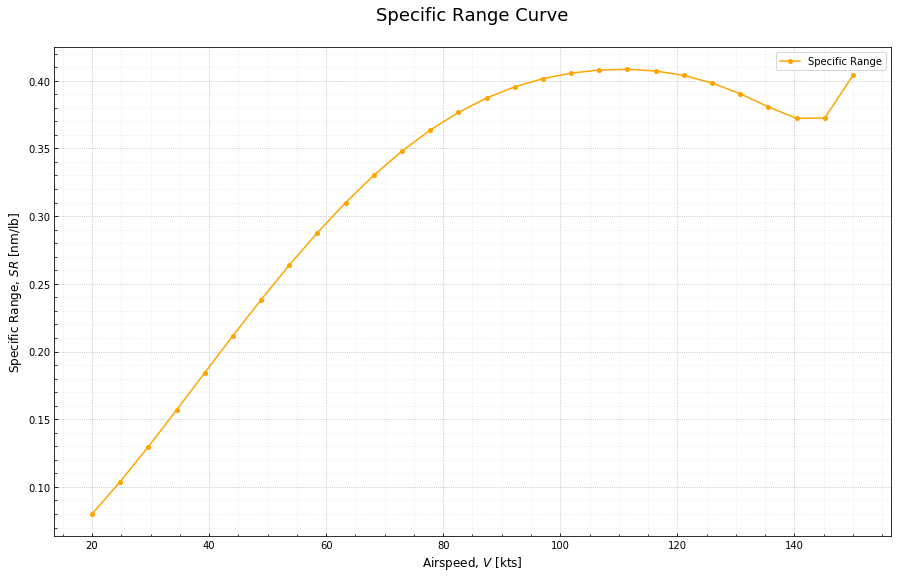

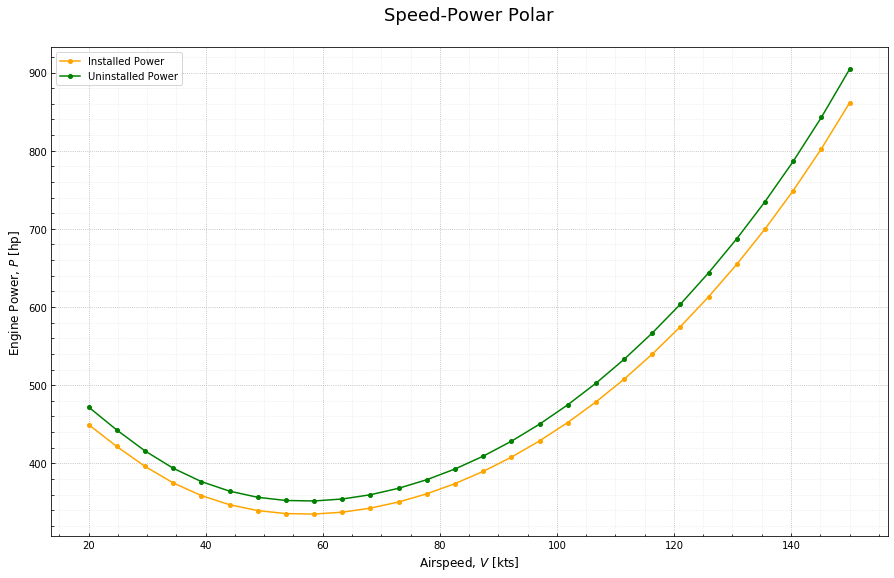

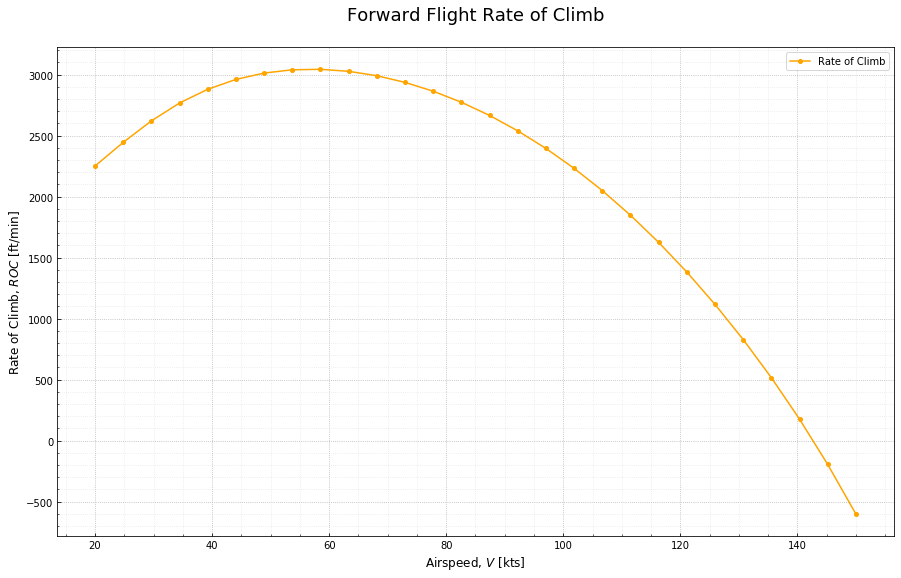

In [149]:
## This cell just plots stuff
def speed_power_polar(data):
    '''
    This function generates a standard speed-power polar plot.
    Input data must have columns following the standard naming
    convention of the helicopter class.
    
    ie. A dataframe output from the Helicopter.forward_flight method
    can be directly supplied.
    '''
    fig, ax = plt.subplots(figsize=(15,9))

    # Add the data and color it
    ax.plot(data.Airspeed, data.SHP_inst_req, color='orange', label='Installed Power', marker='o', markersize='4')
    ax.plot(data.Airspeed, data.SHP_uninst, color='green', label='Uninstalled Power', marker='o', markersize='4')
    ax.legend()

    # Axis labels
    ax.set_xlabel('Airspeed, $V$ [kts]', fontsize=12)
    ax.set_ylabel('Engine Power, $P$ [hp]', fontsize=12)
    ax.set_title('Speed-Power Polar\n', fontsize=18)

    # Move the axis and its label to the top
    # ax.xaxis.set_label_position('top')
    # ax.xaxis.tick_top()

    # Set the ticks
    # ax.xaxis.set_major_locator(ticker.FixedLocator([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
    ax.tick_params(which='minor', width=0.75, length=2.5)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='both', direction='in')

    # Set the grid lines
    ax.grid(b=True, which='major', linestyle=':')
    ax.grid(b=True, which='minor', linestyle=':', alpha=0.3)
    
    return fig, ax


def specific_range(data):
    '''
    This function generates a standard specific range plot.
    Input data must have columns following the standard naming
    convention of the helicopter class.
    
    ie. A dataframe output from the Helicopter.forward_flight method
    can be directly supplied.
    '''
    fig, ax = plt.subplots(figsize=(15,9))

    # Add the data and color it
    ax.plot(data.Airspeed, data.SR, color='orange', label='Specific Range', marker='o', markersize='4')
    ax.legend()

    # Axis labels
    ax.set_xlabel('Airspeed, $V$ [kts]', fontsize=12)
    ax.set_ylabel('Specific Range, $SR$ [nm/lb]', fontsize=12)
    ax.set_title('Specific Range Curve\n', fontsize=18)

    # Move the axis and its label to the top
    # ax.xaxis.set_label_position('top')
    # ax.xaxis.tick_top()

    # Set the ticks
    # ax.xaxis.set_major_locator(ticker.FixedLocator([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
    ax.tick_params(which='minor', width=0.75, length=2.5)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='both', direction='in')

    # Set the grid lines
    ax.grid(b=True, which='major', linestyle=':')
    ax.grid(b=True, which='minor', linestyle=':', alpha=0.3)
    
    return fig, ax


def roc(data):
    '''
    This function generates a standard rate of climb plot.
    Input data must have columns following the standard naming
    convention of the helicopter class.
    
    ie. A dataframe output from the Helicopter.forward_flight method
    can be directly supplied.
    '''
    fig, ax = plt.subplots(figsize=(15,9))

    # Add the data and color it
    ax.plot(data.Airspeed, data.ROC, color='orange', label='Rate of Climb', marker='o', markersize='4')
    ax.legend()

    # Axis labels
    ax.set_xlabel('Airspeed, $V$ [kts]', fontsize=12)
    ax.set_ylabel('Rate of Climb, $ROC$ [ft/min]', fontsize=12)
    ax.set_title('Forward Flight Rate of Climb\n', fontsize=18)

    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(axis='both', which='both', direction='in')

    # Set the grid lines
    ax.grid(b=True, which='major', linestyle=':')
    ax.grid(b=True, which='minor', linestyle=':', alpha=0.3)
    
    return fig, ax

fig, ax = specific_range(data)
fig, ax = speed_power_polar(data)
fig, ax = roc(data)

In [186]:
## Mission Creation

# A mission is a set of misson points, where each point has: a maneuver, an altitude, and a duration (length/range or time).
# Maneuver types include: Idle, Hover, MCP, Flight, Load, or Unload
# Each maneuver type corresponds to a Helicopter class-method.
Point = namedtuple('MissionPoint', ['maneuver', 'altitude', 'duration', 'speed'])
startup = Point('idle', 0, 1, 0)
hover_0 = Point(maneuver='hover', altitude=0, duration=1, speed=0)
climb_0 = Point('MCP', 0, 5, 1000)
cruise_0 = Point('flight', 5000, 165, 120)
descend_0 = Point('flight', 5000, 6.5, 65)  # 65kt can easily maintain -500 ft/min VROC
hover_1 = Point('hover', 0, 1, 0)
unload = Point('unload', 0, 5, 1278)
ground = Point('idle', 0, 1, 0)


mission = (startup, hover_0,
           climb_0, cruise_0,
           hover_1, unload, hover_1,
           climb_0, cruise_0,
           hover_0, ground
          )
mission

(MissionPoint(maneuver='idle', altitude=0, duration=1, speed=0),
 MissionPoint(maneuver='hover', altitude=0, duration=1, speed=0),
 MissionPoint(maneuver='MCP', altitude=0, duration=5, speed=1000),
 MissionPoint(maneuver='flight', altitude=5000, duration=165, speed=120),
 MissionPoint(maneuver='hover', altitude=0, duration=1, speed=0),
 MissionPoint(maneuver='unload', altitude=0, duration=5, speed=1278),
 MissionPoint(maneuver='hover', altitude=0, duration=1, speed=0),
 MissionPoint(maneuver='MCP', altitude=0, duration=5, speed=1000),
 MissionPoint(maneuver='flight', altitude=5000, duration=165, speed=120),
 MissionPoint(maneuver='hover', altitude=0, duration=1, speed=0),
 MissionPoint(maneuver='idle', altitude=0, duration=1, speed=0))

In [190]:
# GW reset for debugging purposes
heli.GW_payload = 1278
heli.GW_fuel = 869

# Mission Loop
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
logging.info('{:^45}'.format('Project Spec Mission'))
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')
# Initialize the range tracker
mission_range = 0
for point in mission:
    if point.maneuver == 'idle':
        burn = heli.idle()/60 * point.duration
        heli.burn(burn)
        logging.info(f'Idled for {point.duration}[mins], burning {burn:.2f}[lbs] of fuel.')
        logging.info(f'   New GW = {heli.GW:.2f}[lbs], fuel: {heli.GW_fuel:.2f}')
        logging.info('')
    elif point.maneuver == 'hover':
        data = heli.HOGE(Environment(point.altitude))
        burn = data['sfc']*data['SHP_unins']*point.duration/60
        heli.burn(burn)
        logging.info(f'Hovered for {point.duration}[mins], burning {burn:.2f}[lbs] of fuel.')
        logging.info(f'   New GW = {heli.GW:.2f}[lbs], fuel: {heli.GW_fuel:.2f}')
        logging.info('')
    elif point.maneuver == 'MCP':
        sfc = heli.bsfc(1.05)
        burn = sfc*1.05*heli.pwr_lim/60
        heli.burn(burn)
        logging.info(f'MCP Climb for {point.duration}[mins] @ {point.speed}[ft/min].')
        logging.info(f'   Burned {burn:.2f}[lbs] of fuel.')
        logging.info(f'   New GW = {heli.GW:.2f}[lbs], fuel: {heli.GW_fuel:.2f}')
        logging.info('')
        mission_range += 120*point.duration/60   # 120 kts has more ROC than 1000 TODO: Calculate this.
    elif point.maneuver == 'flight':
        data = heli.forward_flight(Environment(point.altitude), point.speed)
        burn = point.duration/data.SR[0]
        heli.burn(burn)
        logging.info(f'Forward flight for {point.duration}[nm] @ {point.speed}[kts].')
        logging.info(f'   Burned {burn:.2f}[lbs] of fuel.')
        logging.info(f'   New GW = {heli.GW:.2f}[lbs], fuel: {heli.GW_fuel:.2f}')
        logging.info('')
        mission_range += point.duration 
    elif point.maneuver == 'climb':
        # Represents a hover climb/descent NOT @ MCP
        data = heli.HOGE(Environment(point.altitude), Vroc=point.speed)
        burn = data['sfc']*data['SHP_unins']*point.duration/60
        heli.burn(burn)
        logging.info(f'Climb for {point.duration}[min] @ {point.speed}[ft/min]')
        logging.info(f'   Burned {burn:.2f}[lbs] of fuel.')
        logging.info(f'   New GW = {heli.GW:.2f}[lbs], fuel: {heli.GW_fuel:.2f}')
        logging.info('')
    elif point.maneuver == 'unload':
        logging.info(f'Landed! Unloading {point.speed}[lbs] of cargo.')
        heli.unload(point.speed)
        burn = heli.idle()/60 * point.duration
        heli.burn(burn)
        logging.info(f'Idled for {point.duration}[mins], burning {burn:.2f}[lbs] of fuel.')
        logging.info(f'   New GW = {heli.GW:.2f}[lbs], fuel: {heli.GW_fuel:.2f}')
        logging.info('')
        
logging.info('')
logging.info(f'Mission Complete! {heli.GW_fuel:.2f} [lbs] of fuel remaining.')
logging.info(f'Total Range = {mission_range:.2f}[nm]')
logging.info('-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-')

 2020-04-17 21:20:23,589 -  INFO -  -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 2020-04-17 21:20:23,590 -  INFO -              Project Spec Mission             
 2020-04-17 21:20:23,590 -  INFO -  -.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
 2020-04-17 21:20:23,591 -  INFO -  Idled for 1[mins], burning 2.27[lbs] of fuel.
 2020-04-17 21:20:23,592 -  INFO -     New GW = 4997.73[lbs], fuel: 866.73
 2020-04-17 21:20:23,593 -  INFO -  
 2020-04-17 21:20:23,595 -  INFO -  Hovered for 1[mins], burning 18.39[lbs] of fuel.
 2020-04-17 21:20:23,596 -  INFO -     New GW = 4979.35[lbs], fuel: 848.35
 2020-04-17 21:20:23,597 -  INFO -  
 2020-04-17 21:20:23,597 -  INFO -  MCP Climb for 5[mins] @ 1000[ft/min].
 2020-04-17 21:20:23,597 -  INFO -     Burned 24.90[lbs] of fuel.
 2020-04-17 21:20:23,598 -  INFO -     New GW = 4954.45[lbs], fuel: 823.45
 2020-04-17 21:20:23,598 -  INFO -  
 2020-04-17 21:20:23,638 -  INFO -  Forward flight for 165[nm] @ 120[kts].
 2020-04-17 21:20:23,638 -  INFO -  